### Feature Sampling

지금까지 비정형 금융 데이터 집합으로부터 연속이고 동질이며 구조화된 데이터셋을 생성하는 방법을 배웠다. 머신러닝 알고리즘을 이러한 데이터셋에 적용해 보려 시도할 수 있지만, 대체로 이는 몇 가지 이유로 인해 좋은 아이디어가 되지 못한다.

1. 몇몇 머신러닝 알고리즘은 표본의 크기가 커지면 효율적으로 작동하지 않는다
2. 머신러닝 알고리즘은 연관된 예제로부터 학습할 때 가장 높은 정확성을 보인다

5% 절대값 수익률이 양수일지, 음수일지 예측하고자 한다고 가정해 보자. 임의의 시점에서는 이러한 예측이 정확할 가능성은 낮을 것이다. 그러나 어떤 촉매가 되는 사건이 발생한 이후에 분류 방법론을 사용해 다음 5% 절대 수익률의 부호를 예측한다면 보다 정교한 예측을 할 수 있는 정보 특성을 찾을 가능성이 높다. 앞서 추출한 Bar를 표본 추출하여 연관된 학습 예제가 있는 특성 행렬을 생성하는 방법을 알아보자

In [15]:
from FinancialMachineLearning.barsampling.core import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
data = pd.read_parquet('../../Data/IVEfuture.parquet')
data['date'] = pd.to_datetime(data['date'])
bar = StandardBarFeatures(file_path_or_df = data)

#### 1. Sampling for Reduction

앞서 언급한 것처럼 구조화된 데이터로부터 특성을 표본 추출하는 이유 중 하나는 Machine Learning fitting에 사용될 데이터 양을 줄이기 위한 것이다. 이러한 연산을 Down Sampling이라고 한다. 종종 일정한 단계별 크기로 순차적으로 표본을 추출하거나(`linspace sampling`), 균등분포를 사용해 무작위로 표본 추출(`uniform sampling`)한다

`linspace sampling`의 장점은 단순하다는 것이고, 단점은 단계별 크기가 임의이며, 시드바에 따라 들쭉날쭉하다는 것이다. `uniform sampling`은 이러한 문제를 전체 bar의 집합에서 균일하게 표본 추출해 해결한다. 두 방법은 표본이 정보 내용이나 예측력 관점에서 가장 연관된 관측값을 포함한다는 보장이 없기 때문에 많은 비판을 받는다

#### 2. Event Based Sampling

Portfolio manager는 Structural breaks나 market signal, 또는 microstructural feature등 어떤 사건이 발생한 이후에 베팅한다. 이러한 이벤트들은 변동성 확대, 균형 레벨로부터 spread의 과도한 이탈, 거시 경제 통계량 발표 등과 연계되어 있을 수 있다. 이벤트를 중대한 것으로 특징지을 수 있고, Machine Learning을 활용해 이러한 상황하에서 정교하게 예측할 수 있는 함수가 존재하는지 학습할 수 있다. 아마도 대답은 'no'일 수 있지만, 이런 경우 이벤트 구성을 재정의하거나 다른 특성으로 재시도해볼 수 있다. 예시를 위해 이벤트 기반의 표본 추출 법 중 유용한 것 하나를 살펴보도록 하자

##### 2.1 CUSUM Filter

`Cumulative sum filter`는 품질 통제 기법으로서 측정값이 목표값의 평균으로부터 얼마나 벗어났는지 찾을 수 있도록 설계된다. locally stationary process에서 발생한 $\mathrm{IID}$관측값 $\{y_t\}_{t=1,\dots,T}$를 생각해 보자. Cumulative Sum은 다음과 같이 정의한다.

$$S_t = \max{\{
0, S_{t-1} + y_t - E_{t-1}[y_t]
\}}$$

여기서 경계 조건은 $S_0 = 0$이다. 이 절차는 특정 임계값 $h$(필터 크기)에 대해 $S_t \geq h$를 만족하는 첫 번째 $t$에서의 행동을 추천할 것이다. $y_t \leq E_{t-1}[y_t] - S_{t-1}$일 떄마다 $S_t = 0$이라는 것에 주목하자. 0 하한은 $S_t$가 음수가 되지 못하도록 하방 편차를 무시할 것을 의미한다. 그 이유는 필터가 모든 재설정 레벨 0으로부터 위로 발산하는 sequence를 식별하도록 설정됐기 때문이다. 특히 임계값은 다음의 경우에 활성화된다

$$S_t \geq h \Leftrightarrow \exists \tau \in [1,t] \Big| \sum_{i=\tau}^t \left(
y_t - E_{i-1}[y_t]
\right) \geq h$$

이런 상방 누적의 개념은 하방 누정 개념을 포함해 확장할 수 있는데 이는 대칭 $\mathrm{CUSUM}$ filter를 형성한다

$$S_t^+ = \max{\{
0, S_{t-1}^+ + y_t - E_{t-1}[y_t]
\}}, S_0^+ = 0$$

$$S_t^- = \max{\{
0, S_{t-1}^- + y_t - E_{t-1}[y_t]
\}}, S_0^- = -$$

$$S_t = \max \{S_t^+, S_t^-\}$$

Lam, Yam(1997)은 절대 수익률 $h$가 이전 고점이나 저점에서 발견될 떄 매수 매도 신호를 생성하는 투자 전략을 제안했다. 그들은 해당 전략이 이른바 Fama와 Blume(1966)이 연구한 filter trading strategy와 같다는 것을 증명했다. 여기서 $\mathrm{CUSUM}$ filter 사용 방법은 조금 다르다. $S_t$가 리셋되는 $S_t \geq h$일 때에만 bar $t$를 표본 추출한다. 아래의 코드는 대칭 $\mathrm{CUSUM}$ filter를 보여주며, $E_{t-1}[y_t] = y_{t-1}$이다

In [17]:
dollar = bar.dollar_bar()

Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Returning bars 



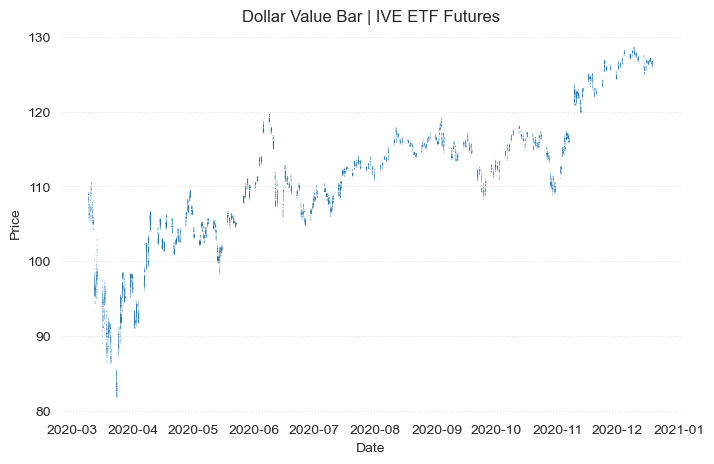

In [18]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    dollar.loc[147500 : 167500]['date_time'],
    dollar.loc[147500 : 167500]['close'],
    s = 1, 
    marker = '.', 
    edgecolor = 'none', 
    alpha = 0.5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Dollar Value Bar | IVE ETF Futures')
plt.show()

In [23]:
from FinancialMachineLearning.filter.filter import cusum_filter

cusum_events = cusum_filter(
    dollar.close, 
    threshold = 1.5, 
    time_stamps = False
)

In [24]:
cusum_filtered = dollar.loc[cusum_events]

In [25]:
cusum_filtered

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
102,2009-10-01 11:34:51,8775,50.39,50.390,50.24,50.26,20349,10595,104,1.023180e+06
188,2009-10-06 09:29:52,16154,50.47,50.920,50.43,50.92,20466,14710,88,1.033263e+06
302,2009-10-14 09:30:00,25958,51.92,52.680,51.91,52.66,19194,13048,74,1.001172e+06
516,2009-10-26 11:32:01,45946,51.58,51.620,51.47,51.48,19450,8514,90,1.002772e+06
583,2009-10-28 12:42:26,51770,50.09,50.090,49.97,49.97,20053,7518,82,1.003064e+06
...,...,...,...,...,...,...,...,...,...,...
236313,2024-03-20 14:04:56,11278232,183.51,183.680,183.50,183.68,5477,3159,36,1.005445e+06
236354,2024-03-21 09:42:40,11279714,184.60,184.750,184.60,184.75,5510,2726,51,1.017568e+06
236454,2024-03-22 16:00:00,11282760,183.92,183.920,183.56,183.56,7143,1151,34,1.311938e+06
236582,2024-03-27 09:35:12,11286519,184.57,184.805,184.57,184.79,5437,3129,37,1.004368e+06


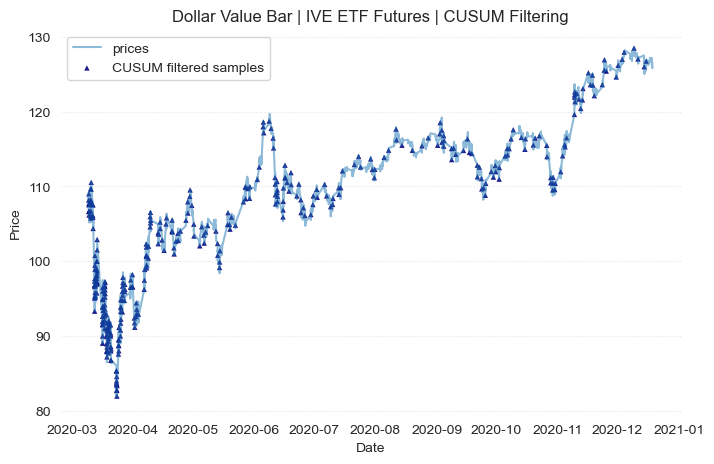

In [26]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    dollar.loc[147500 : 167500]['date_time'],
    dollar.loc[147500 : 167500]['close'],
    alpha = 0.5,
    label = 'prices'
)
ax.scatter(
    cusum_filtered.loc[147500 : 167500]['date_time'],
    cusum_filtered.loc[147500 : 167500]['close'],
    alpha = 0.9,
    marker = '^',
    label = 'CUSUM filtered samples',
    edgecolor = 'none',
    color = 'navy',
    s = 15
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Dollar Value Bar | IVE ETF Futures | CUSUM Filtering')
plt.show()

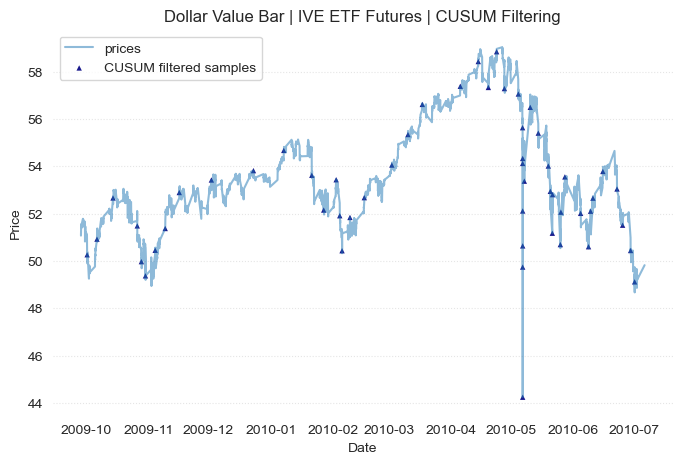

In [27]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    dollar.loc[: 5000]['date_time'],
    dollar.loc[: 5000]['close'],
    alpha = 0.5,
    label = 'prices'
)
ax.scatter(
    cusum_filtered.loc[: 5000]['date_time'],
    cusum_filtered.loc[: 5000]['close'],
    alpha = 0.9,
    marker = '^',
    label = 'CUSUM filtered samples',
    edgecolor = 'none',
    color = 'navy',
    s = 15
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Dollar Value Bar | IVE ETF Futures | CUSUM Filtering')
plt.show()

변수 $S_t$는 Structural Break Statistics, Entropy 또는 Market microstructural featurs 등 모든 특성에 기반을 둘 수 있다. 예를 들어서, Supremum ADF 통계량이 이전의 레벨로부터 충분히 벗어날 때마다 이벤트가 발생할 수 있다

Event driven bar의 부분 집합을 얻으면 이러한 이벤트의 발생이 실행 가능성 정보를 구성하는지를 Machine Learning 알고리즘이 결정하도록 한다